In [ ]:
import pickle
import numpy as np
import awkward
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import uproot
import boost_histogram as bh
import mplhep
import glob
import os
import vector
import shutil
import tqdm

mplhep.style.use("CMS")

In [212]:
matplotlib.rcParams['axes.labelsize'] = 35
legend_fontsize = 30
sample_label_fontsize = 30
addtext_fontsize = 25

jet_label_coords = 0.02, 0.84
jet_label_coords_single = 0.02, 0.88
sample_label_coords = 0.02, 0.96
jet_label_ak4 = "AK4 jets"
jet_label_ak8 = "AK8 jets"
reco_gen_ratio = "Rec. / Gen."

default_cycler = plt.rcParams['axes.prop_cycle']
pf_color = list(default_cycler)[1]["color"]
mlpf_color = list(default_cycler)[2]["color"]

pf_linestyle = "-."
mlpf_linestyle = "-"
data_label = "di-jets 2024B,C"

In [ ]:
import json

def is_in_golden_json(run, luminosity_block, golden_json_data):
    run_str = str(run)
    if run_str not in golden_json_data:
        return False

    lumi_ranges = golden_json_data[run_str]

    for lumi_range in lumi_ranges:
        if len(lumi_range) == 2:
            lumi_first, lumi_last = lumi_range
            if lumi_first <= luminosity_block <= lumi_last:
                return True

    return False

def lumitext():
    mplhep.cms.lumitext(f"{int_lumi:.0f}" + " pb$^{-1}$ (13.6 TeV)")

In [ ]:
import sys

sys.path += ["../../mlpf/plotting/"]
sys.path += ["../../mlpf/"]

import plot_utils
import jet_utils

In [ ]:
def cms_label(ax):
    return plot_utils.experiment_label(ax, experiment="CMS", tag1="Preliminary", tag2="", x1=0.12)

In [ ]:
def load_nano(fn):
    tt = uproot.open(fn).get("Events")
    ret = {}
    for k in [
        "PFMET_pt",
        "PuppiMET_pt",
        "Jet_pt",
        "Jet_nConstituents",
        "Jet_chMultiplicity",
        "Jet_neMultiplicity",
        "Jet_nElectrons",
        "Jet_nMuons",
        "Jet_chEmEF",
        "Jet_chHEF",
        "Jet_hfEmEF",
        "Jet_hfHEF",
        "Jet_muEF",
        "Jet_neEmEF",
        "Jet_neHEF",
        "Electron_pt",
        "Muon_pt",
        "Jet_eta",
        "Jet_phi",
        "Jet_mass",
        "HLT_AK8PFJet500",
        "HLT_PFJet500",
        "HLT_VBF_DiPFJet125_45_Mjj1200",
        "PV_npvsGood",
        "run",
        "luminosityBlock",
        "event",
        "Flag_HBHENoiseFilter",
        "Flag_CSCTightHaloFilter",
        "Flag_hcalLaserEventFilter",
        "Flag_goodVertices",
        "Flag_eeBadScFilter",
        "Flag_ecalLaserCorrFilter",
        "Flag_trkPOGFilters",
    ]:
        ret[k] = tt.arrays(k)[k]
    return [ret, ]

In [ ]:
pf_files = glob.glob("/scratch/local/joosep/mlpf/results/cms/CMSSW_15_0_5_mlpf_v2.4.1/JetMET0_pf/step4_NANO_*.root")
mlpf_new_files = glob.glob("/scratch/local/joosep/mlpf/results/cms/CMSSW_15_0_5_mlpf_v2.5.0_p01_603dc5/JetMET0_mlpfpu/step4_NANO_*.root")

pf_files_d = {os.path.basename(fn): fn for fn in pf_files}
mlpf_new_files_d = {os.path.basename(fn): fn for fn in mlpf_new_files}

common_files = sorted(list(set(pf_files_d.keys()).intersection(set(mlpf_new_files_d.keys()))))
len(common_files)

In [ ]:
tt = uproot.open(pf_files_d[common_files[0]])["Events"]
hlt_pass = []
for k in tt.keys():
    if "HLT_" in k:
        hlt_pass.append((k, np.sum(tt[k].array())))
for k in sorted(hlt_pass, key=lambda x: x[1], reverse=True)[:40]:
    if "Jet" in k[0]:
        print(k)

In [ ]:
def apply_filters(data):
    filt = (
        data["Flag_HBHENoiseFilter"] & 
        data["Flag_CSCTightHaloFilter"] &
        data["Flag_hcalLaserEventFilter"] & 
        data["Flag_goodVertices"] & 
        data["Flag_eeBadScFilter"] & 
        data["Flag_ecalLaserCorrFilter"] & 
        data["Flag_trkPOGFilters"] &
        data["HLT_VBF_DiPFJet125_45_Mjj1200"]
    )
    return filt

In [ ]:
# data_baseline = []
# data_mlpf = []

# for fn in common_files:
#     pf = load_nano(pf_files_d[fn])
#     data_baseline.append(pf)
#     print("pf", np.mean(awkward.num(pf[0]["Jet_pt"], axis=1)))
#     mlpf = load_nano(mlpf_new_files_d[fn])
#     data_mlpf.append(mlpf)
#     print("mlpf", np.mean(awkward.num(mlpf[0]["Jet_pt"], axis=1)))

In [ ]:
from concurrent.futures import ProcessPoolExecutor
def load_multiprocess(files, max_workers=None):
    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        results = list(tqdm.tqdm(executor.map(load_nano, files), total=len(files)))
    successful_results = [r for r in results if r is not None]

    return awkward.concatenate(successful_results)

In [ ]:
data_baseline = load_multiprocess([pf_files_d[fn] for fn in common_files], 16)
data_mlpf =  load_multiprocess([mlpf_new_files_d[fn] for fn in common_files], 16)

data_baseline = awkward.Array({k: awkward.flatten(data_baseline[k], axis=1) for k in data_baseline.fields})
data_mlpf = awkward.Array({k: awkward.flatten(data_mlpf[k], axis=1) for k in data_mlpf.fields})

In [ ]:
print("applying json")
#from https://twiki.cern.ch/twiki/bin/view/CMS/PdmVRun3Analysis
golden = json.load(open("../../Cert_Collisions2024_378981_386951_Golden.json"))
is_golden_pf = np.array([is_in_golden_json(run, lumi, golden) for run, lumi in zip(data_baseline["run"], data_baseline["luminosityBlock"])])
is_golden_mlpf = np.array([is_in_golden_json(run, lumi, golden) for run, lumi in zip(data_mlpf["run"], data_mlpf["luminosityBlock"])])

data_baseline = data_baseline[is_golden_pf & apply_filters(data_baseline)]
data_mlpf = data_mlpf[is_golden_mlpf & apply_filters(data_mlpf)]

In [ ]:
#source /cvmfs/cms-bril.cern.ch/cms-lumi-pog/brilws-docker/brilws-env
#brilcalc lumi --normtag /cvmfs/cms-bril.cern.ch/cms-lumi-pog/Normtags/normtag_BRIL.json -u /fb -i /eos/user/c/cmsdqm/www/CAF/certification/Collisions24/Cert_Collisions2024_378981_386951_Golden.json -o output.csv
import pandas
runs_used = np.unique(data_baseline["run"])
lumi_csv = pandas.read_csv("../../output.csv")
lumi_csv_run = [int(r.split(":")[0]) for r in lumi_csv["#run:fill"]]
lumi_csv["run"] = lumi_csv_run
lumi_csv["used"] = [r in runs_used for r in lumi_csv["run"]]
int_lumi = lumi_csv[lumi_csv["used"]]["recorded(/fb)"].sum()*1000

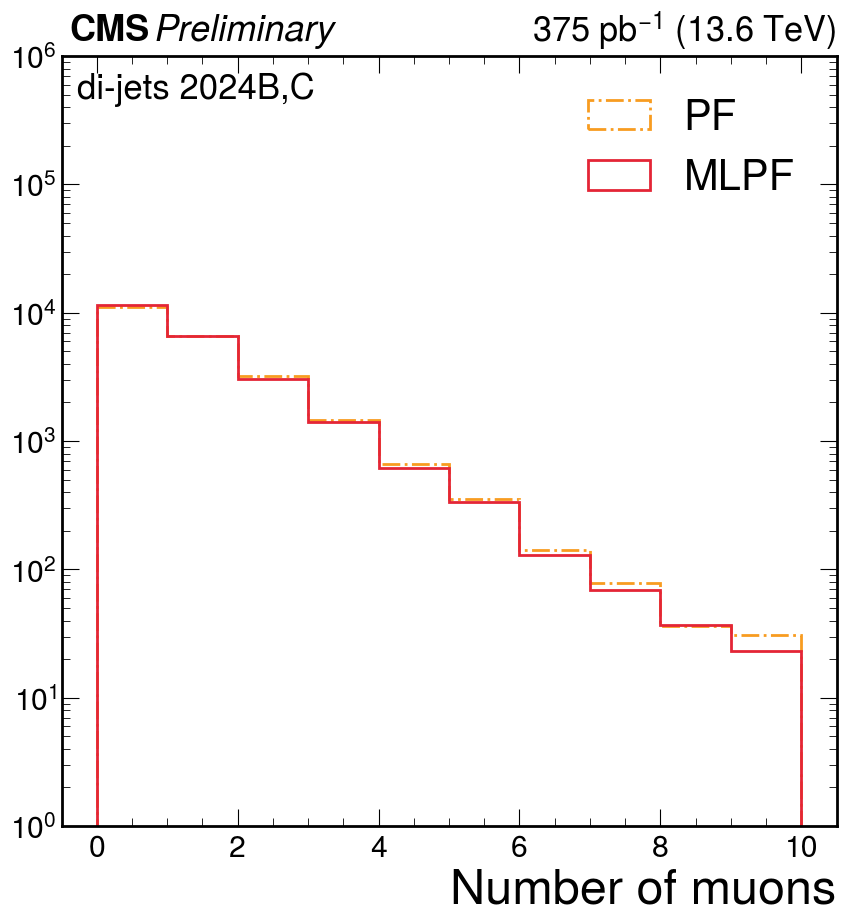

In [213]:
fig = plt.figure()
ax = plt.axes()

bins = np.linspace(0, 10, 11)

plt.plot([], [])
plt.hist(
    awkward.num(data_baseline["Muon_pt"], axis=1),
    bins=bins, histtype="step", label="PF", ls=pf_linestyle, lw=2
);

plt.hist(
    awkward.num(data_mlpf["Muon_pt"], axis=1),
    bins=bins, histtype="step", label="MLPF", ls=mlpf_linestyle, lw=2
);

plt.yscale("log")
cms_label(ax)
lumitext()
plt.text(0.02, 0.98, data_label, transform=ax.transAxes, va="top", fontsize=addtext_fontsize)
plt.ylim(1, 1e6)
plt.legend(loc="best", fontsize=legend_fontsize)
plt.xlabel("Number of muons")
plt.savefig("jetmet0_nmu.pdf")

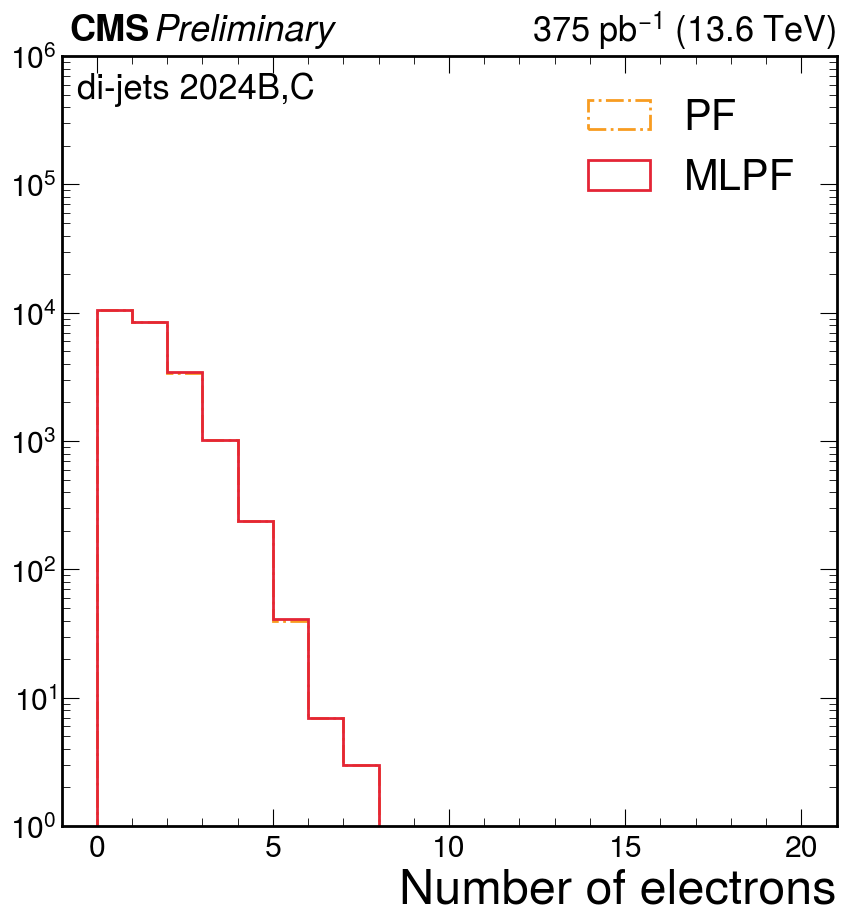

In [214]:
fig = plt.figure()
ax = plt.axes()

bins = np.linspace(0, 20, 21)

plt.plot([], [])
plt.hist(
    awkward.num(data_baseline["Electron_pt"], axis=1),
    bins=bins, histtype="step", label="PF", ls=pf_linestyle, lw=2
);

plt.hist(
    awkward.num(data_mlpf["Electron_pt"], axis=1),
    bins=bins, histtype="step", label="MLPF", ls=mlpf_linestyle, lw=2
);

plt.yscale("log")
cms_label(ax)
lumitext()
plt.text(0.02, 0.98, data_label, transform=ax.transAxes, va="top", fontsize=addtext_fontsize)
plt.ylim(1, 1e6)
plt.legend(loc="best", fontsize=legend_fontsize)
plt.xlabel("Number of electrons")
plt.savefig("jetmet0_nele.pdf")

In [215]:
#https://twiki.cern.ch/twiki/bin/viewauth/CMS/JetID13p6TeV?rev=18
def compute_jetid(data):
    jetid = (
        (np.abs(data["Jet_pt"]) > 20) &
        (np.abs(data["Jet_eta"]) < 2.5) &
        (np.abs(data["Jet_neHEF"]) < 0.9) &
        (np.abs(data["Jet_neEmEF"]) < 0.9) &
        (np.abs(data["Jet_nConstituents"]) > 1) &
        (np.abs(data["Jet_muEF"]) < 0.8) &
        (np.abs(data["Jet_chHEF"]) > 0.01) &
        (np.abs(data["Jet_chMultiplicity"]) > 0) &
        (np.abs(data["Jet_chEmEF"]) < 0.8)
    )
    return jetid

jetid_baseline = compute_jetid(data_baseline)
jetid_mlpf = compute_jetid(data_mlpf)

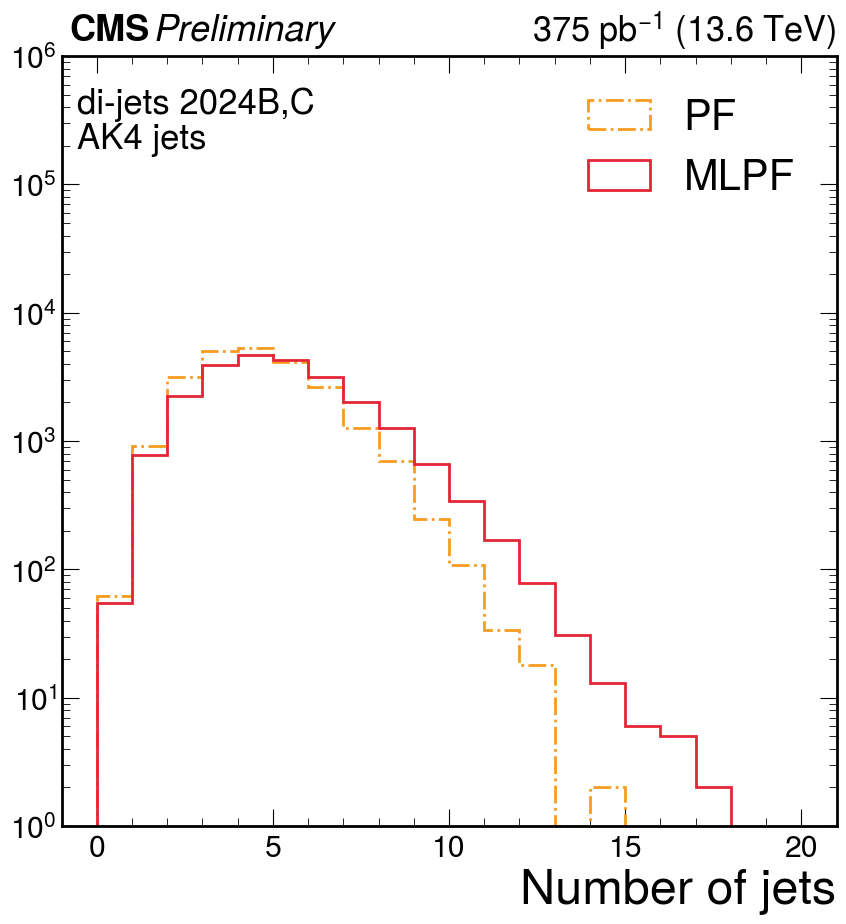

In [216]:
fig = plt.figure()
ax = plt.axes()

bins = np.linspace(0, 20, 21)

plt.plot([], [])
plt.hist(
    awkward.num(data_baseline["Jet_pt"][jetid_baseline], axis=1),
    bins=bins, histtype="step", label="PF", ls=pf_linestyle, lw=2
);

plt.hist(
    awkward.num(data_mlpf["Jet_pt"][jetid_mlpf], axis=1),
    bins=bins, histtype="step", label="MLPF", ls=mlpf_linestyle, lw=2
);

plt.yscale("log")
cms_label(ax)
lumitext()
plt.text(sample_label_coords[0], sample_label_coords[1], data_label, transform=ax.transAxes, va="top", fontsize=addtext_fontsize)
ax.text(jet_label_coords_single[0], jet_label_coords_single[1], jet_label_ak4, transform=ax.transAxes, fontsize=addtext_fontsize)
plt.ylim(1, 1e6)
plt.legend(loc="best", fontsize=legend_fontsize)
plt.xlabel("Number of jets")
plt.savefig("jetmet0_njet.pdf")

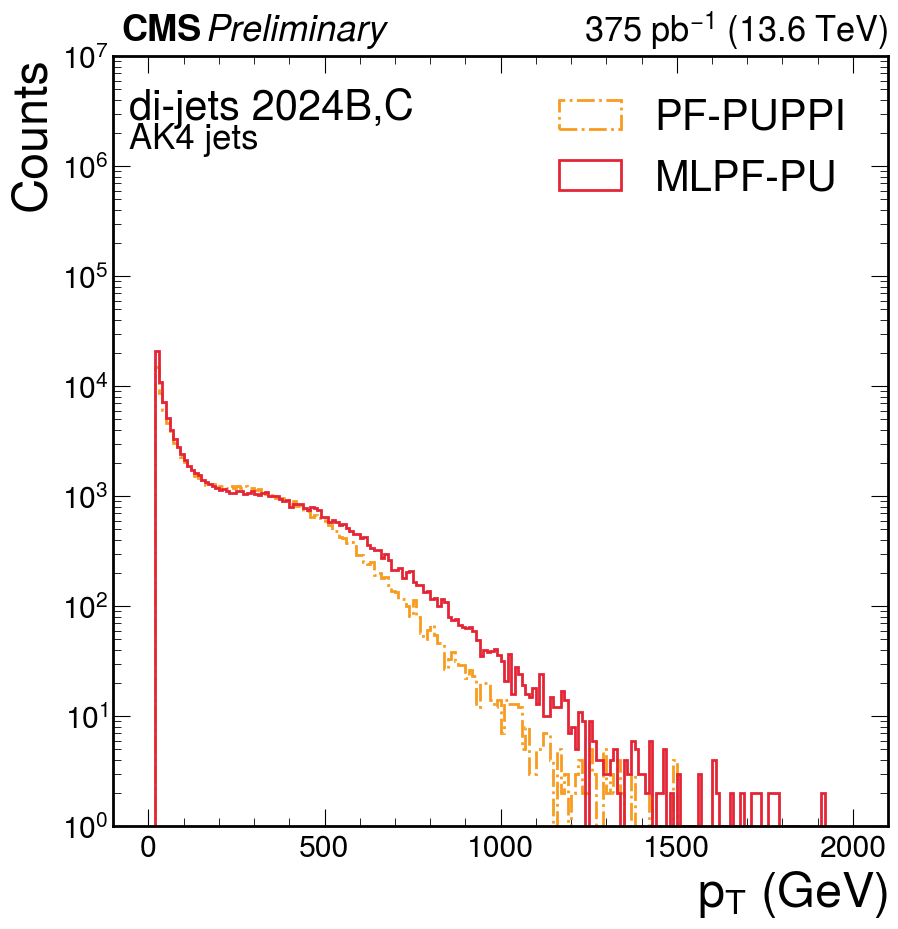

In [217]:
fig = plt.figure()
ax = plt.axes()

bins = np.linspace(0, 2000, 201)

plt.plot([], [])
plt.hist(
    awkward.flatten(data_baseline["Jet_pt"][jetid_baseline], axis=1),
    bins=bins, histtype="step", label="PF-PUPPI", ls=pf_linestyle, lw=2
);

plt.hist(
    awkward.flatten(data_mlpf["Jet_pt"][jetid_mlpf], axis=1),
    bins=bins, histtype="step", label="MLPF-PU", ls=mlpf_linestyle, lw=2
);

plt.yscale("log")
cms_label(ax)
lumitext()
plt.text(sample_label_coords[0], sample_label_coords[1], data_label, transform=ax.transAxes, va="top", fontsize=sample_label_fontsize)
ax.text(jet_label_coords_single[0], jet_label_coords_single[1], jet_label_ak4, transform=ax.transAxes, fontsize=addtext_fontsize)
plt.ylim(1, 1e7)
plt.legend(loc="best", fontsize=legend_fontsize)
plt.xlabel(plot_utils.labels["pt"])
plt.ylabel("Counts")
plt.savefig("jetmet0_jet_pt.pdf")

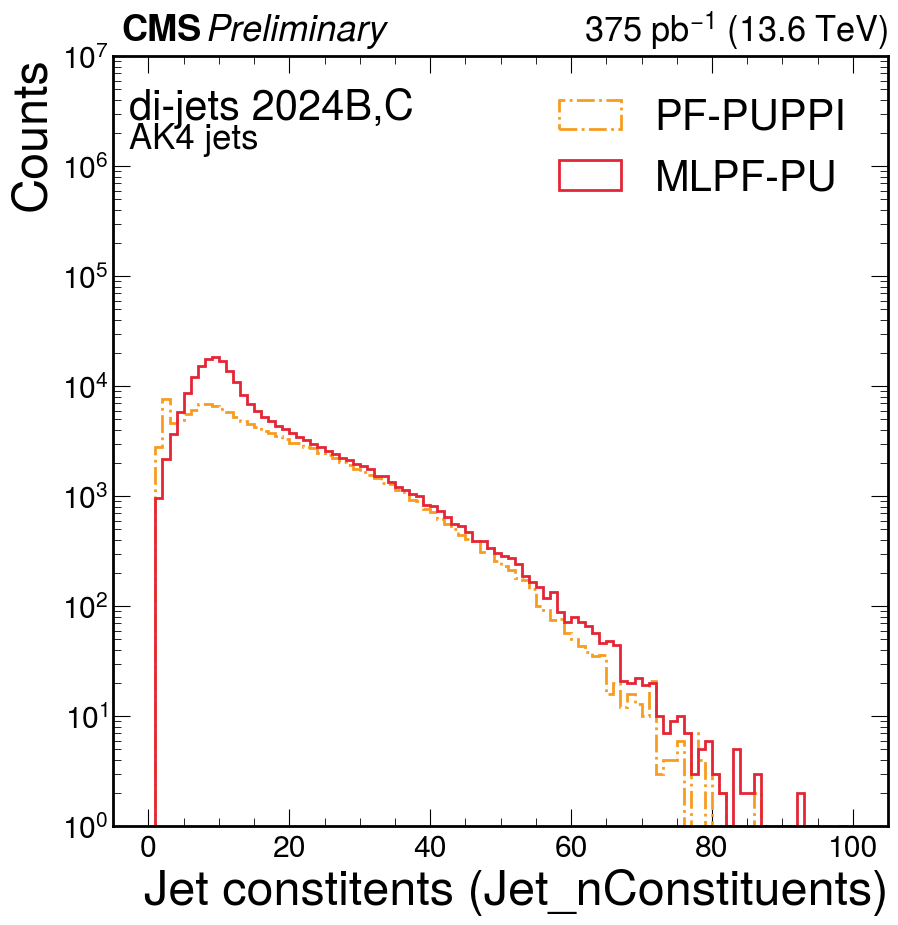

In [218]:
fig = plt.figure()
ax = plt.axes()

bins = np.linspace(0, 100, 101)

plt.plot([], [])
plt.hist(
    awkward.flatten(data_baseline["Jet_nConstituents"], axis=1),
    bins=bins, histtype="step", label="PF-PUPPI", ls=pf_linestyle, lw=2
);

plt.hist(
    awkward.flatten(data_mlpf["Jet_nConstituents"], axis=1),
    bins=bins, histtype="step", label="MLPF-PU", ls=mlpf_linestyle, lw=2
);
# plt.hist(
#     awkward.flatten(awkward.Array(data_mlpf[0])["Jet_pt"]),
#     bins=np.linspace(10,100,21), histtype="step", label="MLPF"
# );

plt.yscale("log")
cms_label(ax)
lumitext()
plt.text(sample_label_coords[0], sample_label_coords[1], data_label, transform=ax.transAxes, va="top", fontsize=sample_label_fontsize)
ax.text(jet_label_coords_single[0], jet_label_coords_single[1], jet_label_ak4, transform=ax.transAxes, fontsize=addtext_fontsize)
plt.ylim(1, 1e7)
plt.legend(loc="best", fontsize=legend_fontsize)
plt.xlabel("Jet constitents (Jet_nConstituents)")
plt.ylabel("Counts")
plt.savefig("jetmet0_jet_nConstituents.pdf")

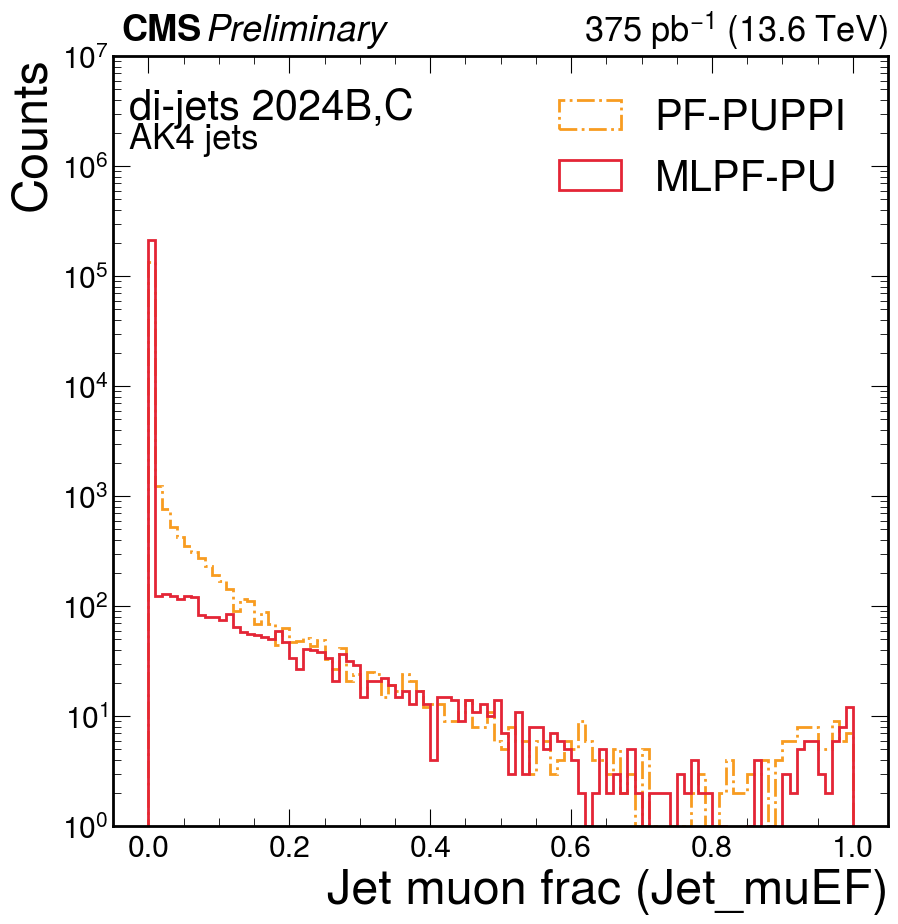

In [219]:
fig = plt.figure()
ax = plt.axes()

bins = np.linspace(0, 1, 101)

plt.plot([], [])
plt.hist(
    awkward.flatten(data_baseline["Jet_muEF"], axis=1),
    bins=bins, histtype="step", label="PF-PUPPI", ls=pf_linestyle, lw=2
);

plt.hist(
    awkward.flatten(data_mlpf["Jet_muEF"], axis=1),
    bins=bins, histtype="step", label="MLPF-PU", ls=mlpf_linestyle, lw=2
);
# plt.hist(
#     awkward.flatten(awkward.Array(data_mlpf[0])["Jet_pt"]),
#     bins=np.linspace(10,100,21), histtype="step", label="MLPF"
# );

plt.yscale("log")
cms_label(ax)
lumitext()
plt.text(sample_label_coords[0], sample_label_coords[1], data_label, transform=ax.transAxes, va="top", fontsize=sample_label_fontsize)
ax.text(jet_label_coords_single[0], jet_label_coords_single[1], jet_label_ak4, transform=ax.transAxes, fontsize=addtext_fontsize)
plt.ylim(1, 1e7)
plt.legend(loc="best", fontsize=legend_fontsize)
plt.xlabel("Jet muon frac (Jet_muEF)")
plt.ylabel("Counts")
plt.savefig("jetmet0_jet_muEF.pdf")

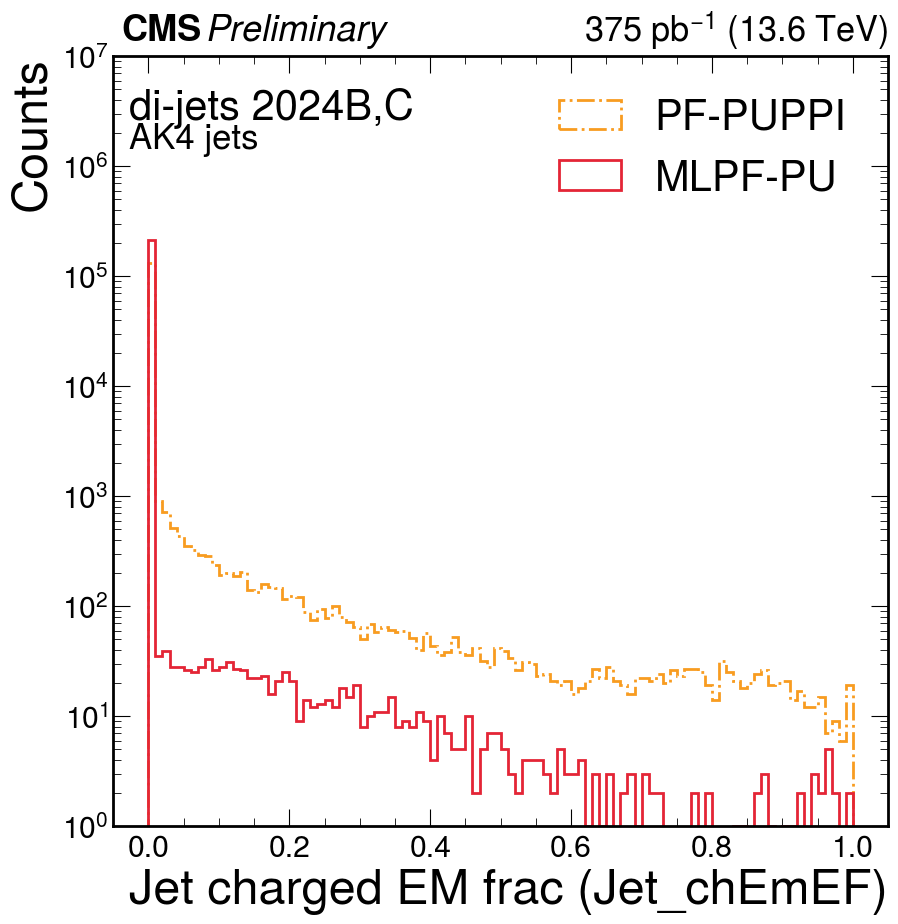

In [220]:
fig = plt.figure()
ax = plt.axes()

bins = np.linspace(0, 1, 101)

plt.plot([], [])
plt.hist(
    awkward.flatten(data_baseline["Jet_chEmEF"], axis=1),
    bins=bins, histtype="step", label="PF-PUPPI", ls=pf_linestyle, lw=2
);

plt.hist(
    awkward.flatten(data_mlpf["Jet_chEmEF"], axis=1),
    bins=bins, histtype="step", label="MLPF-PU", ls=mlpf_linestyle, lw=2
);

plt.yscale("log")
cms_label(ax)
lumitext()
plt.text(sample_label_coords[0], sample_label_coords[1], data_label, transform=ax.transAxes, va="top", fontsize=sample_label_fontsize)
ax.text(jet_label_coords_single[0], jet_label_coords_single[1], jet_label_ak4, transform=ax.transAxes, fontsize=addtext_fontsize)
plt.ylim(1, 1e7)
plt.legend(loc="best", fontsize=legend_fontsize)
plt.xlabel("Jet charged EM frac (Jet_chEmEF)")
plt.ylabel("Counts")
plt.savefig("jetmet0_jet_chEmEF.pdf")

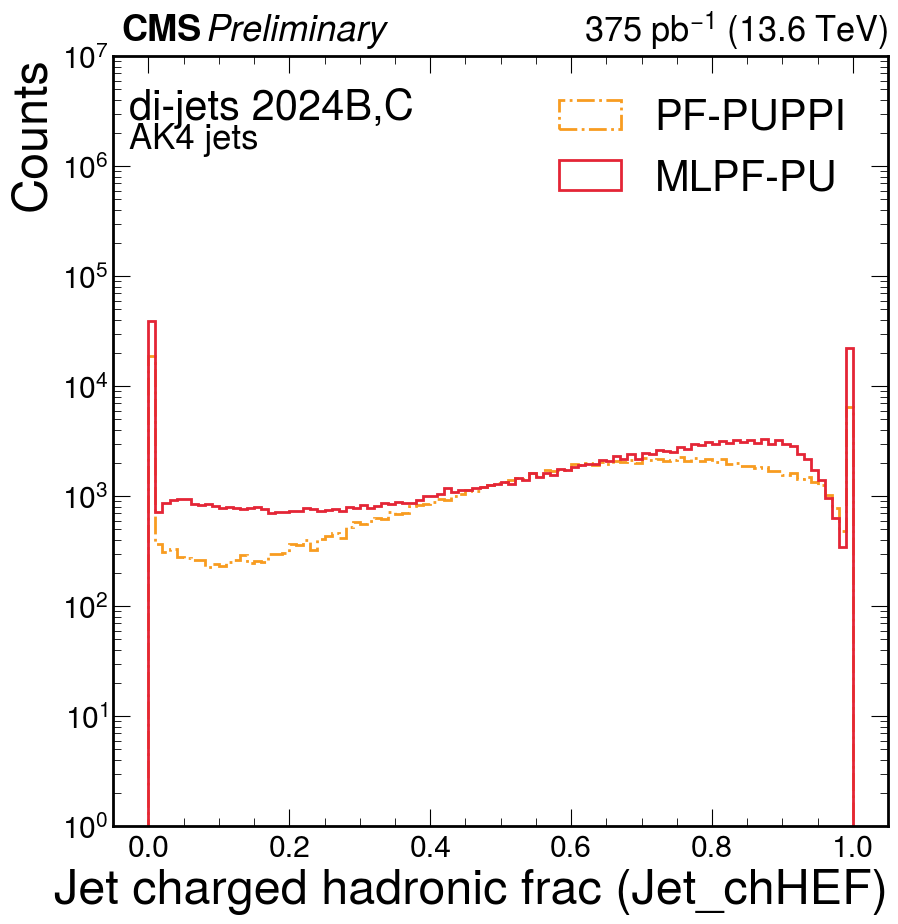

In [221]:
fig = plt.figure()
ax = plt.axes()

bins = np.linspace(0, 1, 101)

plt.plot([], [])
plt.hist(
    awkward.flatten(data_baseline["Jet_chHEF"], axis=1),
    bins=bins, histtype="step", label="PF-PUPPI", ls=pf_linestyle, lw=2
);

plt.hist(
    awkward.flatten(data_mlpf["Jet_chHEF"], axis=1),
    bins=bins, histtype="step", label="MLPF-PU", ls=mlpf_linestyle, lw=2
);

plt.yscale("log")
cms_label(ax)
lumitext()
plt.text(sample_label_coords[0], sample_label_coords[1], data_label, transform=ax.transAxes, va="top", fontsize=sample_label_fontsize)
ax.text(jet_label_coords_single[0], jet_label_coords_single[1], jet_label_ak4, transform=ax.transAxes, fontsize=addtext_fontsize)
plt.ylim(1, 1e7)
plt.legend(loc="best", fontsize=legend_fontsize)
plt.xlabel("Jet charged hadronic frac (Jet_chHEF)")
plt.ylabel("Counts")
plt.savefig("jetmet0_jet_chHEF.pdf")

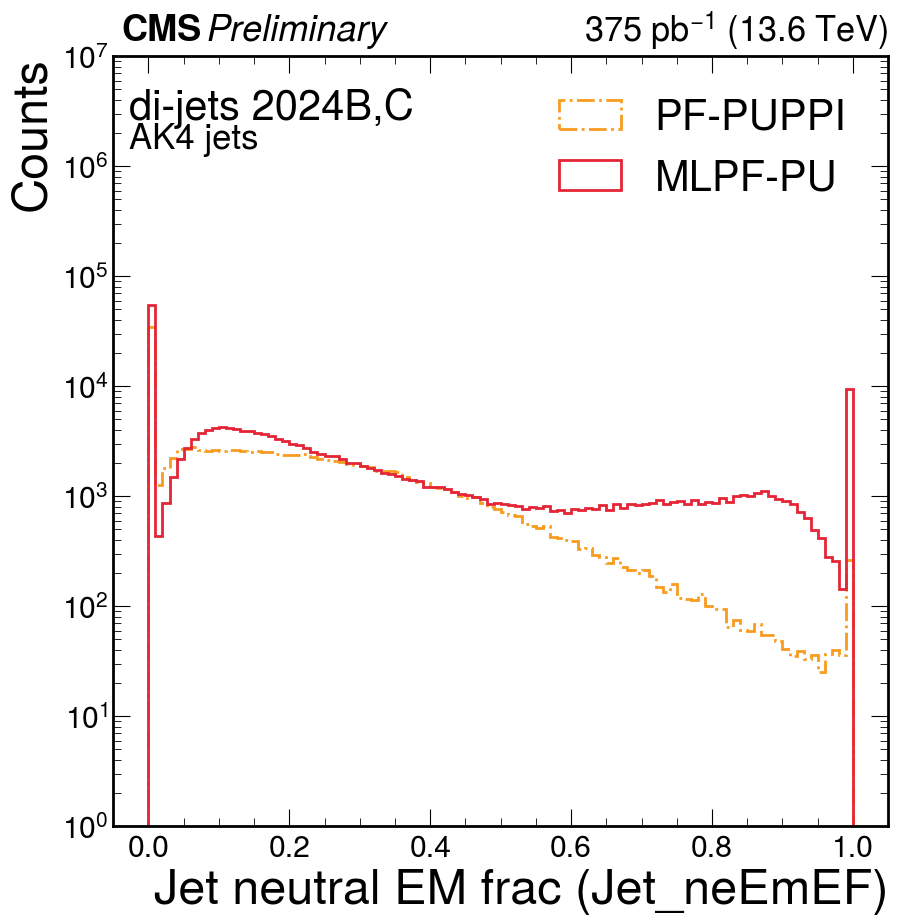

In [222]:
fig = plt.figure()
ax = plt.axes()

bins = np.linspace(0, 1, 101)

plt.plot([], [])
plt.hist(
    awkward.flatten(data_baseline["Jet_neEmEF"], axis=1),
    bins=bins, histtype="step", label="PF-PUPPI", ls=pf_linestyle, lw=2
);

plt.hist(
    awkward.flatten(data_mlpf["Jet_neEmEF"], axis=1),
    bins=bins, histtype="step", label="MLPF-PU", ls=mlpf_linestyle, lw=2
);

plt.yscale("log")
cms_label(ax)
lumitext()
plt.text(sample_label_coords[0], sample_label_coords[1], data_label, transform=ax.transAxes, va="top", fontsize=sample_label_fontsize)
ax.text(jet_label_coords_single[0], jet_label_coords_single[1], jet_label_ak4, transform=ax.transAxes, fontsize=addtext_fontsize)
plt.ylim(1, 1e7)
plt.legend(loc="best", fontsize=legend_fontsize)
plt.xlabel("Jet neutral EM frac (Jet_neEmEF)")
plt.ylabel("Counts")
plt.savefig("jetmet0_jet_neEmEF.pdf")

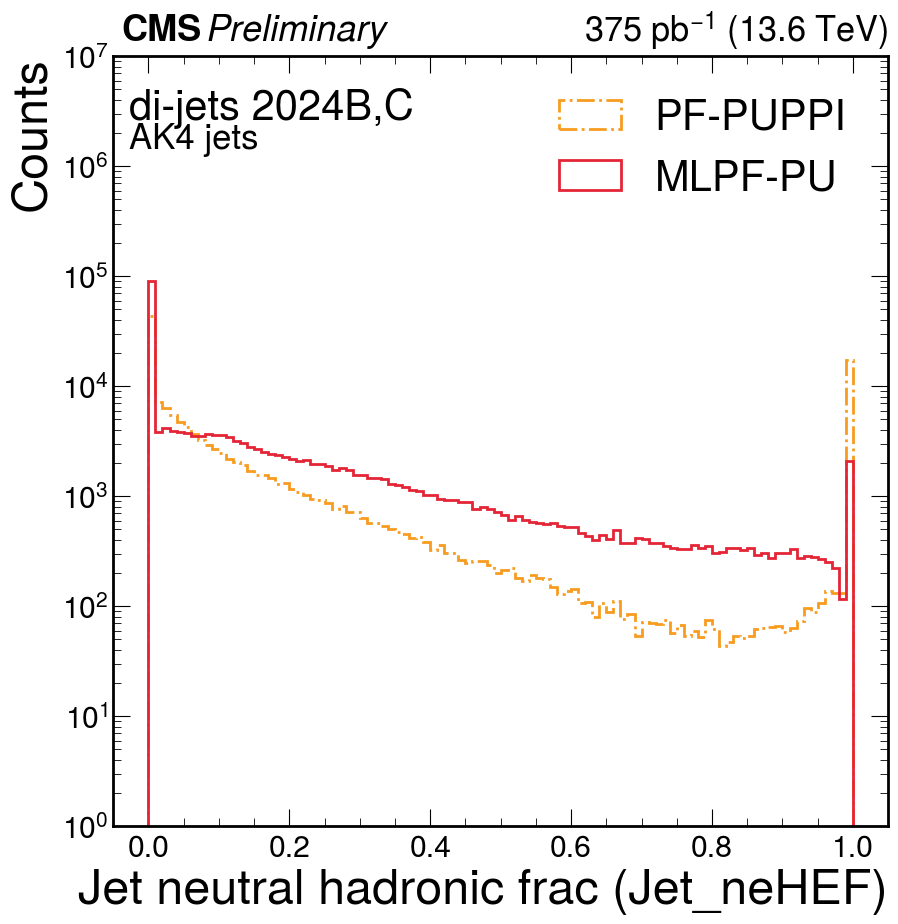

In [223]:
fig = plt.figure()
ax = plt.axes()

bins = np.linspace(0, 1, 101)

plt.plot([], [])
plt.hist(
    awkward.flatten(data_baseline["Jet_neHEF"], axis=1),
    bins=bins, histtype="step", label="PF-PUPPI", ls=pf_linestyle, lw=2
);

plt.hist(
    awkward.flatten(data_mlpf["Jet_neHEF"], axis=1),
    bins=bins, histtype="step", label="MLPF-PU", ls=mlpf_linestyle, lw=2
);

plt.yscale("log")
cms_label(ax)
lumitext()
plt.text(sample_label_coords[0], sample_label_coords[1], data_label, transform=ax.transAxes, va="top", fontsize=sample_label_fontsize)
ax.text(jet_label_coords_single[0], jet_label_coords_single[1], jet_label_ak4, transform=ax.transAxes, fontsize=addtext_fontsize)
plt.ylim(1, 1e7)
plt.legend(loc="best", fontsize=legend_fontsize)
plt.xlabel("Jet neutral hadronic frac (Jet_neHEF)")
plt.ylabel("Counts")
plt.savefig("jetmet0_jet_neHEF.pdf")

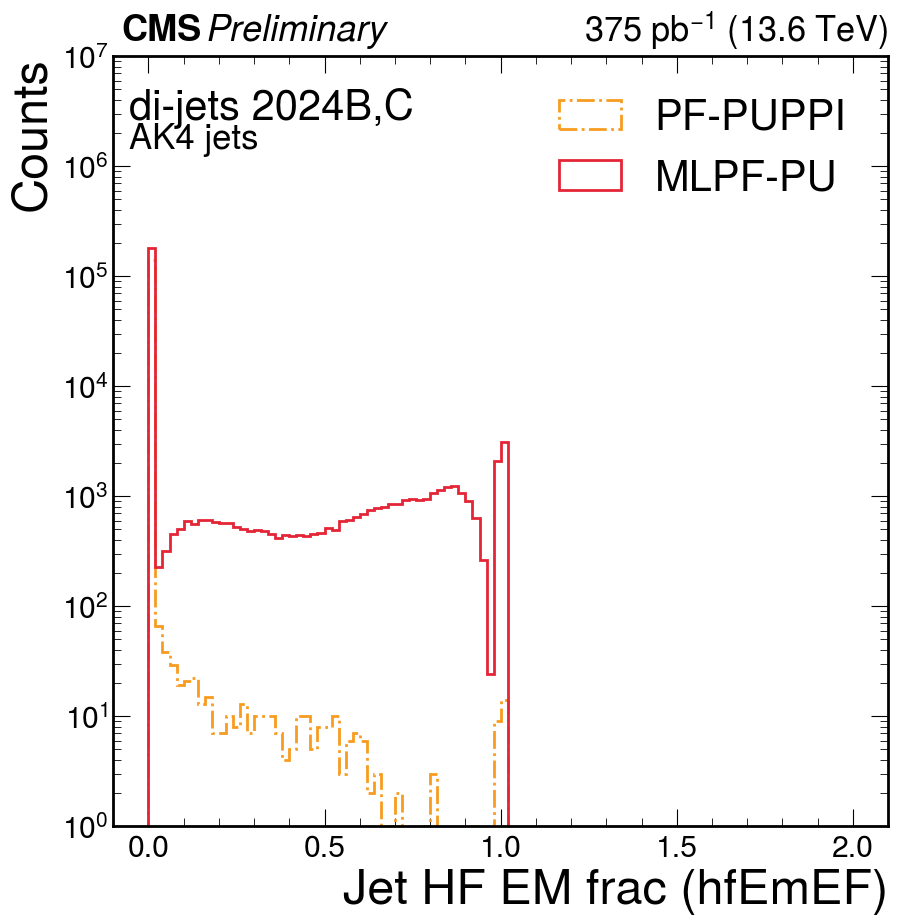

In [224]:
fig = plt.figure()
ax = plt.axes()

bins = np.linspace(0, 2, 101)

plt.plot([], [])
plt.hist(
    awkward.flatten(data_baseline["Jet_hfEmEF"], axis=1),
    bins=bins, histtype="step", label="PF-PUPPI", ls=pf_linestyle, lw=2
);

plt.hist(
    awkward.flatten(data_mlpf["Jet_hfEmEF"], axis=1),
    bins=bins, histtype="step", label="MLPF-PU", ls=mlpf_linestyle, lw=2
);

plt.yscale("log")
cms_label(ax)
lumitext()
plt.text(sample_label_coords[0], sample_label_coords[1], data_label, transform=ax.transAxes, va="top", fontsize=sample_label_fontsize)
ax.text(jet_label_coords_single[0], jet_label_coords_single[1], jet_label_ak4, transform=ax.transAxes, fontsize=addtext_fontsize)
plt.ylim(1, 1e7)
plt.legend(loc="best", fontsize=legend_fontsize)
plt.xlabel("Jet HF EM frac (hfEmEF)")
plt.ylabel("Counts")
plt.savefig("jetmet0_jet_hfEmEF.pdf")

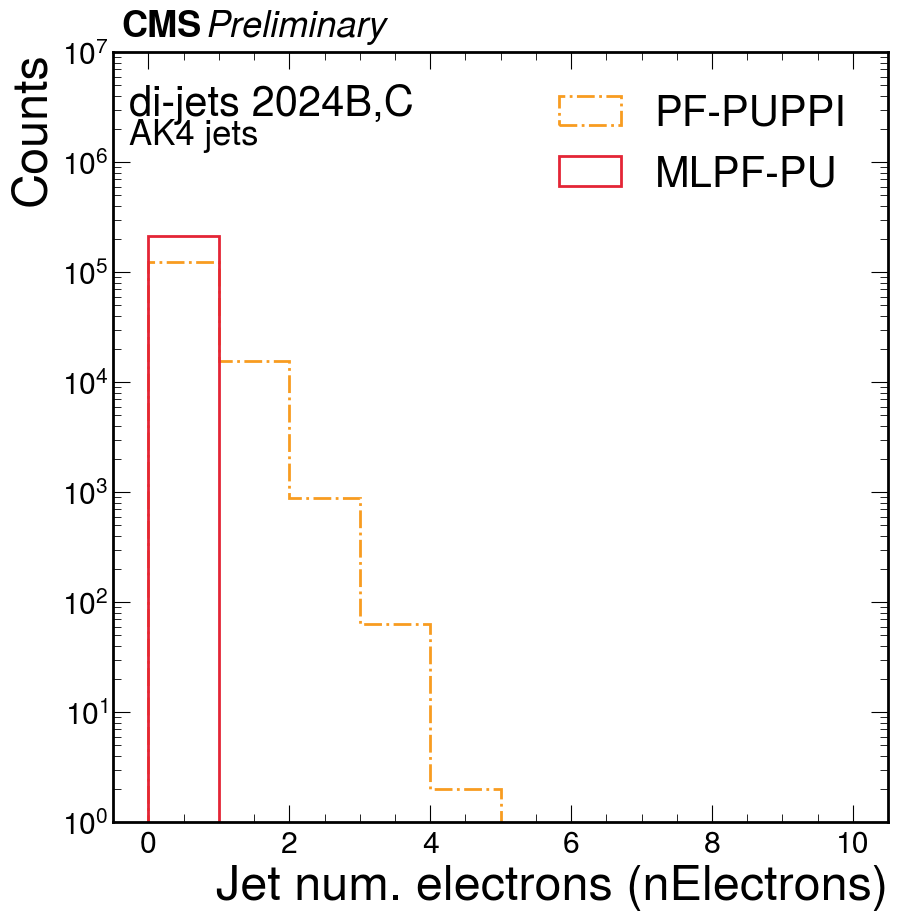

In [225]:
fig = plt.figure()
ax = plt.axes()

bins = np.linspace(0, 10, 11)

plt.plot([], [])
plt.hist(
    awkward.flatten(data_baseline["Jet_nElectrons"], axis=1),
    bins=bins, histtype="step", label="PF-PUPPI", ls=pf_linestyle, lw=2
);

plt.hist(
    awkward.flatten(data_mlpf["Jet_nElectrons"], axis=1),
    bins=bins, histtype="step", label="MLPF-PU", ls=mlpf_linestyle, lw=2
);

plt.yscale("log")
cms_label(ax)
plt.text(sample_label_coords[0], sample_label_coords[1], data_label, transform=ax.transAxes, va="top", fontsize=sample_label_fontsize)
ax.text(jet_label_coords_single[0], jet_label_coords_single[1], jet_label_ak4, transform=ax.transAxes, fontsize=addtext_fontsize)
plt.ylim(1, 1e7)
plt.legend(loc="best", fontsize=legend_fontsize)
plt.xlabel("Jet num. electrons (nElectrons)")
plt.ylabel("Counts")
plt.savefig("jetmet0_jet_nele.pdf")

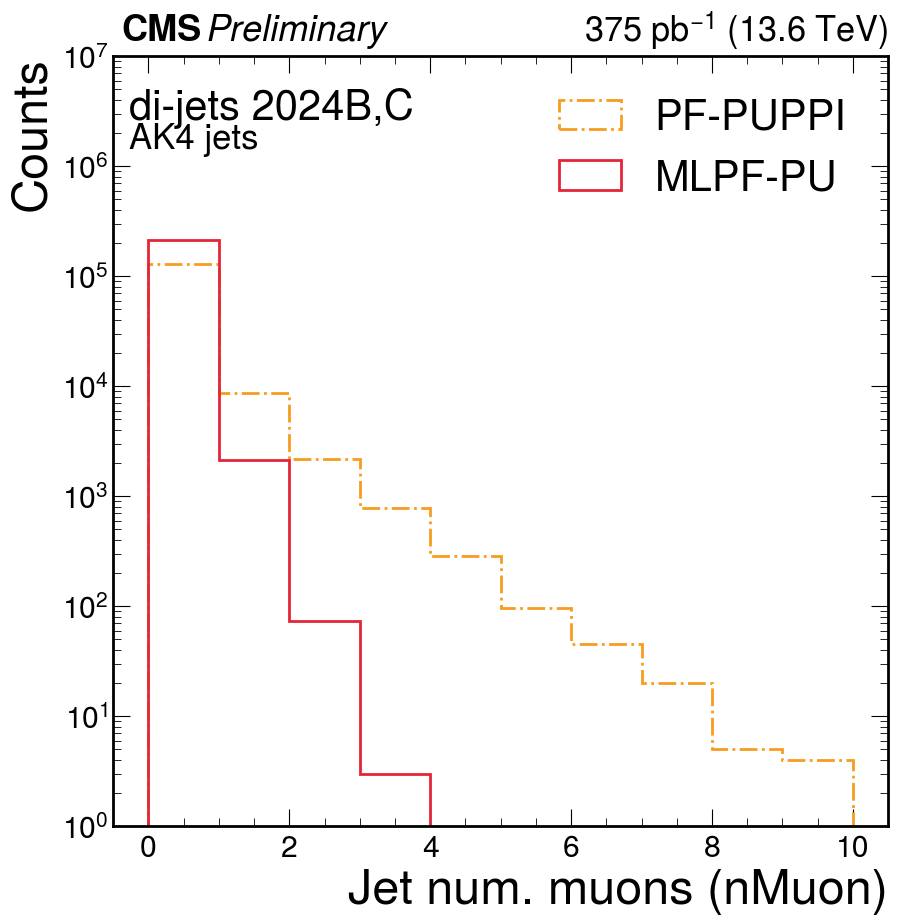

In [226]:
fig = plt.figure()
ax = plt.axes()

bins = np.linspace(0, 10, 11)

plt.plot([], [])
plt.hist(
    awkward.flatten(data_baseline["Jet_nMuons"], axis=1),
    bins=bins, histtype="step", label="PF-PUPPI", ls=pf_linestyle, lw=2
);

plt.hist(
    awkward.flatten(data_mlpf["Jet_nMuons"], axis=1),
    bins=bins, histtype="step", label="MLPF-PU", ls=mlpf_linestyle, lw=2
);

plt.yscale("log")
cms_label(ax)
lumitext()
plt.text(sample_label_coords[0], sample_label_coords[1], data_label, transform=ax.transAxes, va="top", fontsize=sample_label_fontsize)
ax.text(jet_label_coords_single[0], jet_label_coords_single[1], jet_label_ak4, transform=ax.transAxes, fontsize=addtext_fontsize)
plt.ylim(1, 1e7)
plt.legend(loc="best", fontsize=legend_fontsize)
plt.xlabel("Jet num. muons (nMuon)")
plt.ylabel("Counts")
plt.savefig("jetmet0_jet_nmu.pdf")

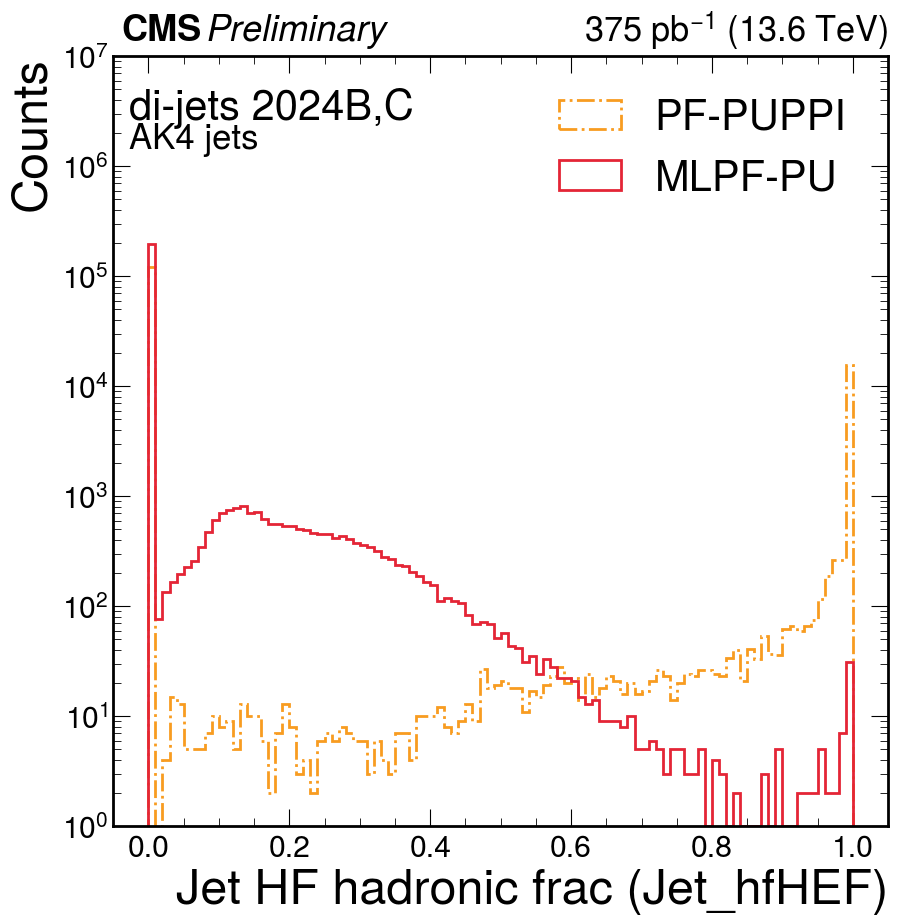

In [227]:
fig = plt.figure()
ax = plt.axes()

bins = np.linspace(0, 1, 101)

plt.plot([], [])
plt.hist(
    awkward.flatten(data_baseline["Jet_hfHEF"], axis=1),
    bins=bins, histtype="step", label="PF-PUPPI", ls=pf_linestyle, lw=2
);

plt.hist(
    awkward.flatten(data_mlpf["Jet_hfHEF"], axis=1),
    bins=bins, histtype="step", label="MLPF-PU", ls=mlpf_linestyle, lw=2
);

plt.yscale("log")
cms_label(ax)
lumitext()
plt.text(sample_label_coords[0], sample_label_coords[1], data_label, transform=ax.transAxes, va="top", fontsize=sample_label_fontsize)
ax.text(jet_label_coords_single[0], jet_label_coords_single[1], jet_label_ak4, transform=ax.transAxes, fontsize=addtext_fontsize)
plt.ylim(1, 1e7)
plt.legend(loc="best", fontsize=legend_fontsize)
plt.xlabel("Jet HF hadronic frac (Jet_hfHEF)")
plt.ylabel("Counts")
plt.savefig("jetmet0_jet_hfHEF.pdf")

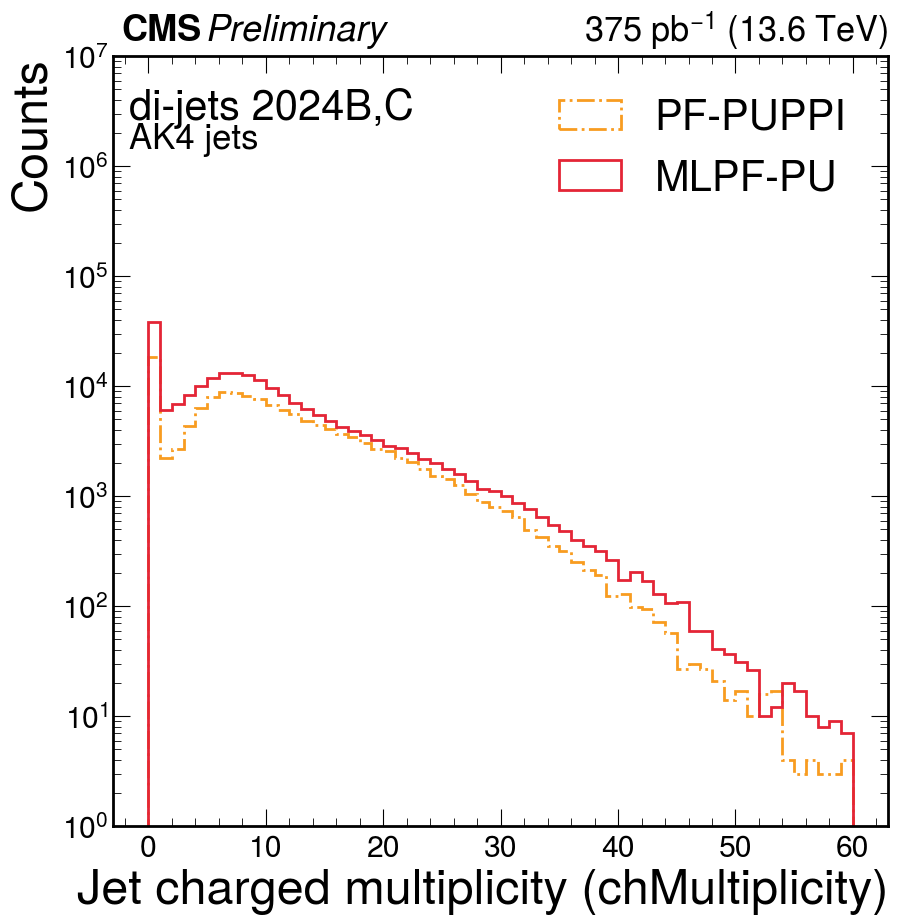

In [228]:
fig = plt.figure()
ax = plt.axes()

bins = np.linspace(0, 60, 61)

plt.plot([], [])
plt.hist(
    awkward.flatten(data_baseline["Jet_chMultiplicity"], axis=1),
    bins=bins, histtype="step", label="PF-PUPPI", ls=pf_linestyle, lw=2
);

plt.hist(
    awkward.flatten(data_mlpf["Jet_chMultiplicity"], axis=1),
    bins=bins, histtype="step", label="MLPF-PU", ls=mlpf_linestyle, lw=2
);

plt.yscale("log")
cms_label(ax)
lumitext()
plt.text(sample_label_coords[0], sample_label_coords[1], data_label, transform=ax.transAxes, va="top", fontsize=sample_label_fontsize)
ax.text(jet_label_coords_single[0], jet_label_coords_single[1], jet_label_ak4, transform=ax.transAxes, fontsize=addtext_fontsize)
plt.ylim(1, 1e7)
plt.legend(loc="best", fontsize=legend_fontsize)
plt.xlabel("Jet charged multiplicity (chMultiplicity)")
plt.ylabel("Counts")
plt.savefig("jetmet0_jet_ch_mult.pdf")

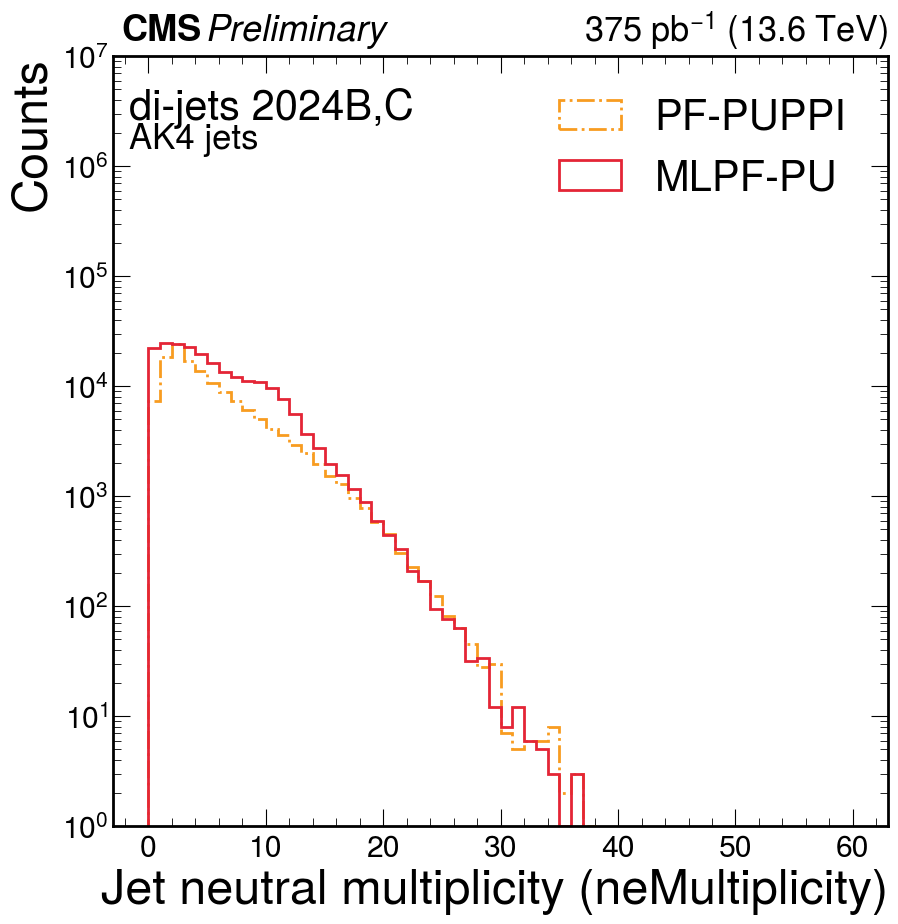

In [229]:
fig = plt.figure()
ax = plt.axes()

bins = np.linspace(0, 60, 61)

plt.plot([], [])
plt.hist(
    awkward.flatten(data_baseline["Jet_neMultiplicity"], axis=1),
    bins=bins, histtype="step", label="PF-PUPPI", ls=pf_linestyle, lw=2
);

plt.hist(
    awkward.flatten(data_mlpf["Jet_neMultiplicity"], axis=1),
    bins=bins, histtype="step", label="MLPF-PU", ls=mlpf_linestyle, lw=2
);

plt.yscale("log")
cms_label(ax)
lumitext()
plt.text(sample_label_coords[0], sample_label_coords[1], data_label, transform=ax.transAxes, va="top", fontsize=sample_label_fontsize)
ax.text(jet_label_coords_single[0], jet_label_coords_single[1], jet_label_ak4, transform=ax.transAxes, fontsize=addtext_fontsize)
plt.ylim(1, 1e7)
plt.legend(loc="best", fontsize=legend_fontsize)
plt.xlabel("Jet neutral multiplicity (neMultiplicity)")
plt.ylabel("Counts")
plt.savefig("jetmet0_jet_ne_mult.pdf")

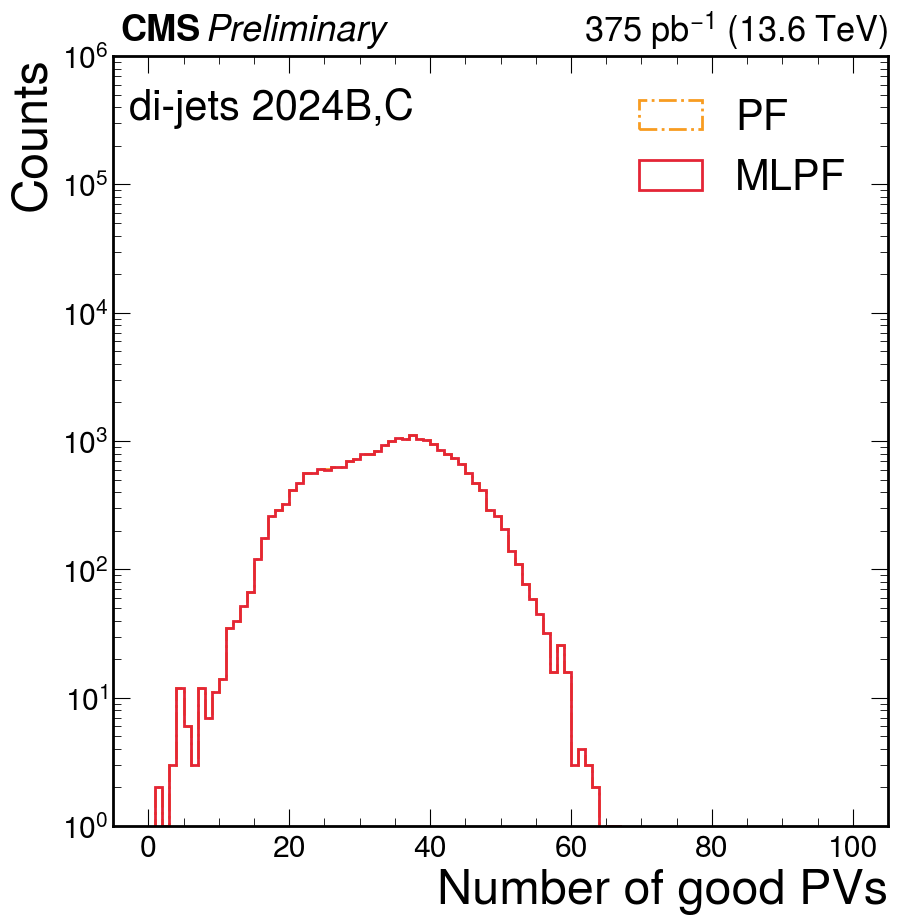

In [230]:
fig = plt.figure()
ax = plt.axes()

bins = np.linspace(0, 100, 101)

plt.plot([], [])
plt.hist(
    data_baseline["PV_npvsGood"],
    bins=bins, histtype="step", label="PF", ls=pf_linestyle, lw=2
);

plt.hist(
    data_mlpf["PV_npvsGood"],
    bins=bins, histtype="step", label="MLPF", ls=mlpf_linestyle, lw=2
);
# plt.hist(
#     awkward.flatten(awkward.Array(data_mlpf[0])["Jet_pt"]),
#     bins=np.linspace(10,100,21), histtype="step", label="MLPF"
# );

plt.yscale("log")
cms_label(ax)
lumitext()
plt.text(sample_label_coords[0], sample_label_coords[1], data_label, transform=ax.transAxes, va="top", fontsize=sample_label_fontsize)
plt.ylim(1, 1e6)
plt.legend(loc="best", fontsize=legend_fontsize)
plt.xlabel("Number of good PVs")
plt.ylabel("Counts")
plt.savefig("jetmet0_npvs.pdf")

In [231]:
def get_jet_pt(data):
    jetid = compute_jetid(data)
    high_pt_jets = (data["Jet_pt"]>60) & (np.abs(data["Jet_eta"])<2.5) & jetid
    two_good_jets = awkward.sum(high_pt_jets, axis=1)>1

    # Reject events with additional jets with pt > 5 GeV
    # First identify all jets with pt > 5 GeV
    low_pt_jets = (data["Jet_pt"] > 5) & jetid
    # Count how many such jets in each event
    n_low_pt_jets = awkward.sum(low_pt_jets, axis=1)
    # Keep only events with exactly 2 jets above 5 GeV
    # DISABLED for now!
    # exactly_two_jets_mask = (n_low_pt_jets == 2)
    exactly_two_jets_mask = (n_low_pt_jets >= 2)

    mask_2_jets = two_good_jets & exactly_two_jets_mask
    evs_2_jets = data[mask_2_jets]
    njets = np.arange(len(evs_2_jets["Jet_pt"]))

    jet_indices = awkward.argsort(evs_2_jets["Jet_pt"], axis=1, ascending=False)
    leading_jet = jet_indices[:, 0]
    subleading_jet = jet_indices[:, 1]

    leading_jet_pt = evs_2_jets["Jet_pt"][njets, leading_jet]
    subleading_jet_pt = evs_2_jets["Jet_pt"][njets, subleading_jet]
    leading_jet_eta = evs_2_jets["Jet_eta"][njets, leading_jet]
    subleading_jet_eta = evs_2_jets["Jet_eta"][njets, subleading_jet]
    leading_jet_phi = evs_2_jets["Jet_phi"][njets, leading_jet]
    subleading_jet_phi = evs_2_jets["Jet_phi"][njets, subleading_jet]
    leading_jet_mass = evs_2_jets["Jet_mass"][njets, leading_jet]
    subleading_jet_mass = evs_2_jets["Jet_mass"][njets, subleading_jet]
    
    delta_phi = abs(leading_jet_phi - subleading_jet_phi)
    delta_phi = np.minimum(delta_phi, 2*np.pi - delta_phi)
    back_to_back_mask = delta_phi > 2.7

    # Apply back-to-back mask to all variables
    delta_phi = delta_phi[back_to_back_mask]
    leading_jet_pt = leading_jet_pt[back_to_back_mask]
    subleading_jet_pt = subleading_jet_pt[back_to_back_mask]
    leading_jet_eta = leading_jet_eta[back_to_back_mask]
    subleading_jet_eta = subleading_jet_eta[back_to_back_mask]
    leading_jet_phi = leading_jet_phi[back_to_back_mask]
    subleading_jet_phi = subleading_jet_phi[back_to_back_mask]
    leading_jet_mass = leading_jet_mass[back_to_back_mask]
    subleading_jet_mass = subleading_jet_mass[back_to_back_mask]
    
    # Calculate four-momentum components for both jets
    # Energy components
    leading_energy = np.sqrt(leading_jet_pt**2 * np.cosh(leading_jet_eta)**2 + leading_jet_mass**2)
    subleading_energy = np.sqrt(subleading_jet_pt**2 * np.cosh(subleading_jet_eta)**2 + subleading_jet_mass**2)
    
    # Momentum components
    leading_px = leading_jet_pt * np.cos(leading_jet_phi)
    leading_py = leading_jet_pt * np.sin(leading_jet_phi)
    leading_pz = leading_jet_pt * np.sinh(leading_jet_eta)
    
    subleading_px = subleading_jet_pt * np.cos(subleading_jet_phi)
    subleading_py = subleading_jet_pt * np.sin(subleading_jet_phi)
    subleading_pz = subleading_jet_pt * np.sinh(subleading_jet_eta)
    
    # Calculate invariant mass using the full 4-vector formula
    dijet_mass = np.sqrt((leading_energy + subleading_energy)**2 - 
                        (leading_px + subleading_px)**2 - 
                        (leading_py + subleading_py)**2 -
                        (leading_pz + subleading_pz)**2)

    return mask_2_jets, leading_jet_pt, subleading_jet_pt, dijet_mass

In [232]:
evmask_pf, lj_pt_pf, slj_pt_pf, dijet_mass_pf = get_jet_pt(data_baseline)
evmask_mlpf, lj_pt_mlpf, slj_pt_mlpf, dijet_mass_mlpf = get_jet_pt(data_mlpf)

In [233]:
event_label = data_label + "\n$\geq 2$ jets, $p_T>60$ GeV, $|\eta|<2.5$"

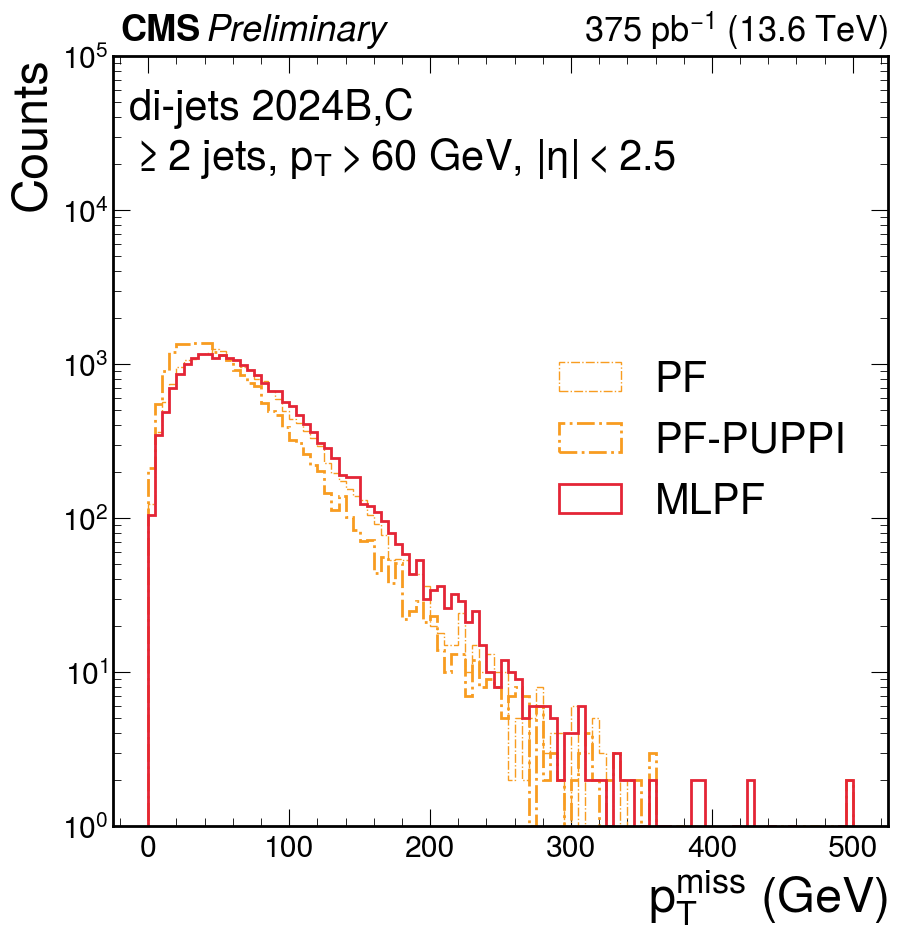

In [234]:
fig = plt.figure()
ax = plt.axes()

bins = np.linspace(0, 500, 101)

plt.plot([], [])
x = plt.hist(
    data_baseline["PFMET_pt"][evmask_pf],
    bins=bins, histtype="step", label="PF", ls=pf_linestyle, lw=1
);

plt.hist(
    data_baseline["PuppiMET_pt"][evmask_pf],
    bins=bins, histtype="step", label="PF-PUPPI", ls=pf_linestyle, lw=2, color=x[2][0].get_edgecolor()
);

x = plt.hist(
    data_mlpf["PFMET_pt"][evmask_mlpf],
    bins=bins, histtype="step", label="MLPF", ls=mlpf_linestyle, lw=2
);

# plt.hist(
#     data_mlpf["PuppiMET_pt"][evmask_mlpf],
#     bins=bins, histtype="step", label="MLPF-PUPPI", ls=mlpf_linestyle, lw=1, color=x[2][0].get_edgecolor()
# );
# plt.hist(
#     awkward.flatten(awkward.Array(data_mlpf[0])["Jet_pt"]),
#     bins=np.linspace(10,100,21), histtype="step", label="MLPF"
# );

plt.yscale("log")
cms_label(ax)
lumitext()
plt.text(sample_label_coords[0], sample_label_coords[1], event_label, transform=ax.transAxes, va="top", fontsize=sample_label_fontsize)
plt.ylim(1, 1e5)
plt.legend(loc="best", fontsize=legend_fontsize)
plt.xlabel(plot_utils.labels["met"])
plt.ylabel("Counts")
plt.savefig("jetmet0_met.pdf")

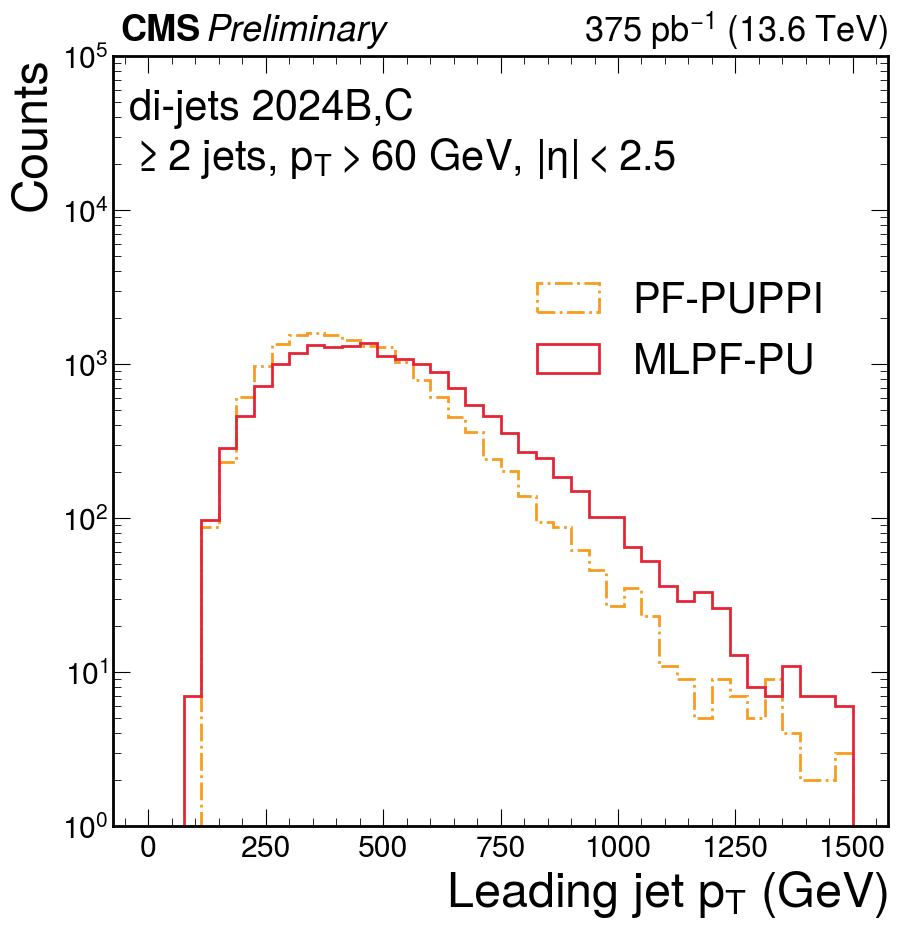

In [235]:
fig = plt.figure()
ax = plt.axes()

bins = np.linspace(0, 1500, 41)

plt.plot([], [])
plt.hist(
    lj_pt_pf,
    bins=bins, histtype="step", label="PF-PUPPI", ls=pf_linestyle, lw=2
);

plt.hist(
    lj_pt_mlpf,
    bins=bins, histtype="step", label="MLPF-PU", ls=mlpf_linestyle, lw=2
);
# plt.hist(
#     awkward.flatten(awkward.Array(data_mlpf[0])["Jet_pt"]),
#     bins=np.linspace(10,100,21), histtype="step", label="MLPF"
# );

plt.yscale("log")
cms_label(ax)
lumitext()
plt.text(sample_label_coords[0], sample_label_coords[1], event_label, transform=ax.transAxes, va="top", fontsize=sample_label_fontsize)
plt.ylim(1, 1e5)
plt.legend(loc=(0.52, 0.55), fontsize=legend_fontsize)
plt.xlabel("Leading jet " + plot_utils.labels["pt"])
plt.ylabel("Counts")
plt.savefig("jetmet0_leading_jet_pt.pdf")

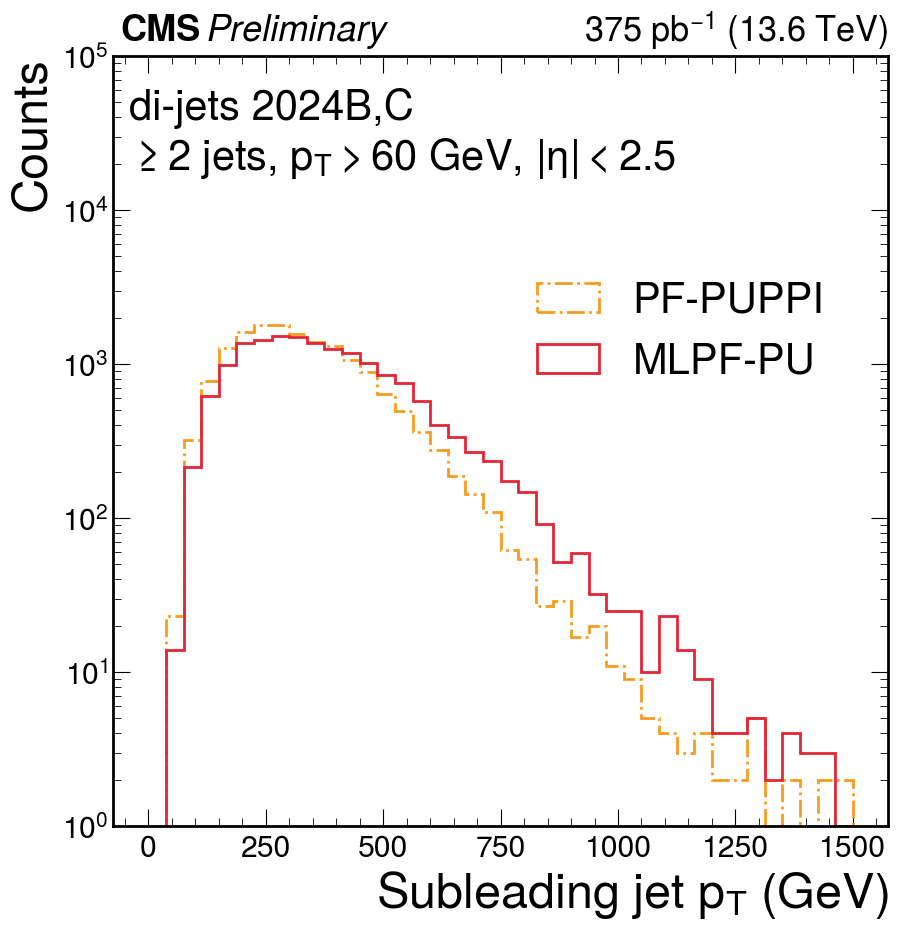

In [236]:
fig = plt.figure()
ax = plt.axes()

bins = np.linspace(0, 1500, 41)

plt.plot([], [])
plt.hist(
    slj_pt_pf,
    bins=bins, histtype="step", label="PF-PUPPI", ls=pf_linestyle, lw=2
);
plt.hist(
    slj_pt_mlpf,
    bins=bins, histtype="step", label="MLPF-PU", ls=mlpf_linestyle, lw=2
);
# plt.hist(s
#     awkward.flatten(awkward.Array(data_mlpf[0])["Jet_pt"]),
#     bins=np.linspace(10,100,21), histtype="step", label="MLPF"
# );

plt.yscale("log")
cms_label(ax)
lumitext()
plt.text(sample_label_coords[0], sample_label_coords[1], event_label, transform=ax.transAxes, va="top", fontsize=sample_label_fontsize)
plt.ylim(1, 1e5)
plt.legend(loc=(0.52, 0.55), fontsize=legend_fontsize)
plt.xlabel("Subleading jet " + plot_utils.labels["pt"])
plt.ylabel("Counts")
plt.savefig("jetmet0_subleading_jet_pt.pdf")

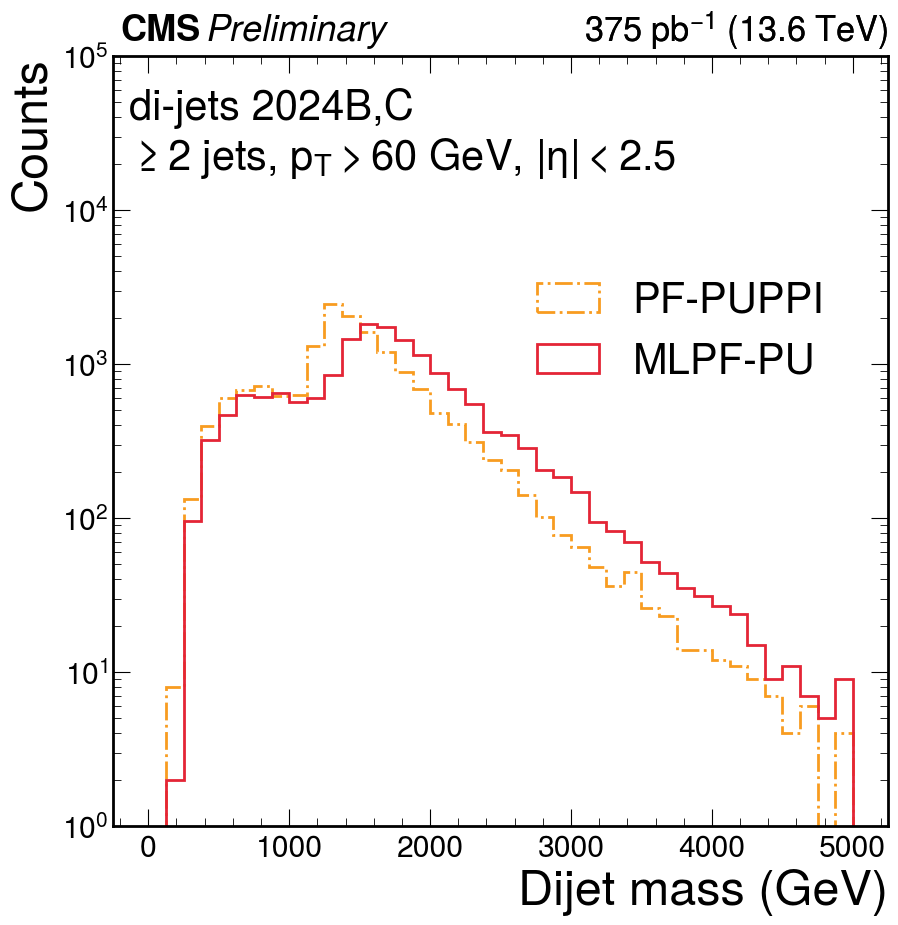

In [237]:
fig = plt.figure()
ax = plt.axes()

bins = np.linspace(0, 5000, 41)

plt.plot([], [])
plt.hist(
    dijet_mass_pf,
    bins=bins, histtype="step", label="PF-PUPPI", ls=pf_linestyle, lw=2
);

plt.hist(
    dijet_mass_mlpf,
    bins=bins, histtype="step", label="MLPF-PU", ls=mlpf_linestyle, lw=2
);
# plt.hist(
#     awkward.flatten(awkward.Array(data_mlpf[0])["Jet_pt"]),
#     bins=np.linspace(10,100,21), histtype="step", label="MLPF"
# );

plt.yscale("log")
cms_label(ax)
lumitext()
plt.text(sample_label_coords[0], sample_label_coords[1], event_label, transform=ax.transAxes, va="top", fontsize=sample_label_fontsize)
mplhep.cms.lumitext(f"{int_lumi:.0f}" + " pb$^{-1}$ (13.6 TeV)")
plt.ylim(1, 1e5)
plt.legend(loc=(0.52, 0.55), fontsize=legend_fontsize)
plt.xlabel("Dijet mass (GeV)")
plt.ylabel("Counts")
plt.savefig("jetmet0_dijet_mass.pdf")

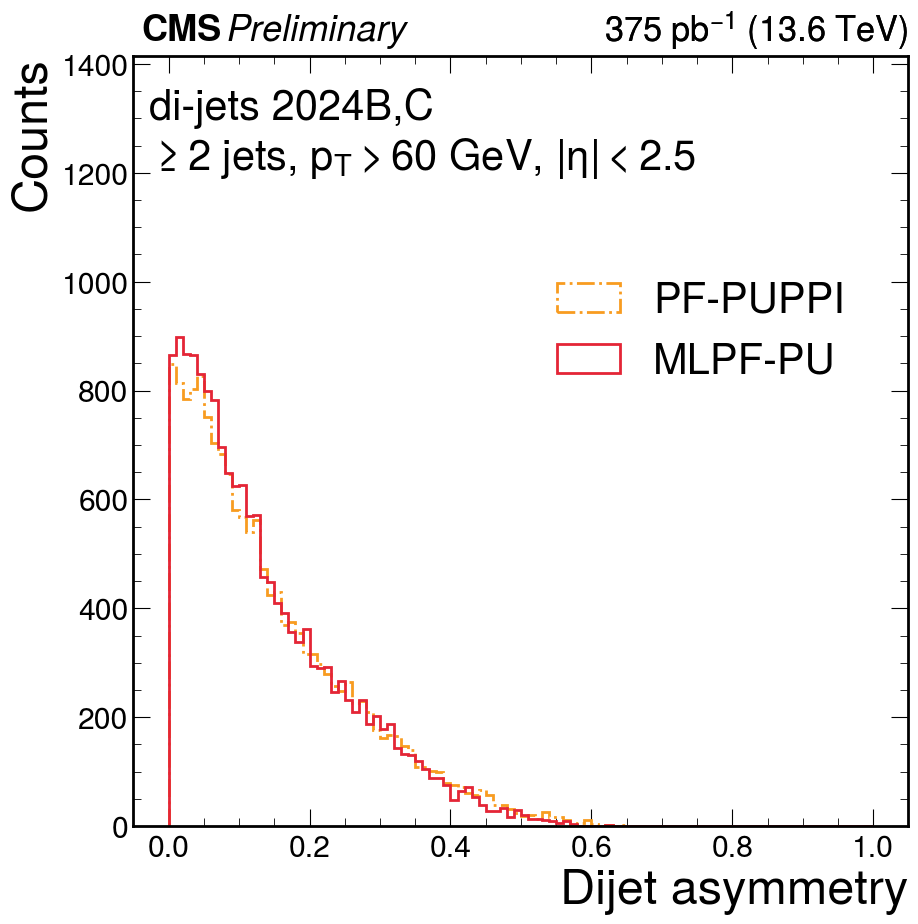

In [238]:
fig = plt.figure()
ax = plt.axes()

bins = np.linspace(0, 1, 101)

plt.plot([], [])
plt.hist(
    (lj_pt_pf - slj_pt_pf)/(lj_pt_pf + slj_pt_pf),
    bins=bins, histtype="step", label="PF-PUPPI", ls=pf_linestyle, lw=2
);
plt.hist(
    (lj_pt_mlpf - slj_pt_mlpf)/(lj_pt_mlpf + slj_pt_mlpf),
    bins=bins, histtype="step", label="MLPF-PU", ls=mlpf_linestyle, lw=2
);
# plt.hist(s
#     awkward.flatten(awkward.Array(data_mlpf[0])["Jet_pt"]),
#     bins=np.linspace(10,100,21), histtype="step", label="MLPF"
# );

#plt.yscale("log")
cms_label(ax)
lumitext()
plt.text(sample_label_coords[0], sample_label_coords[1], event_label, transform=ax.transAxes, va="top", fontsize=sample_label_fontsize)
mplhep.cms.lumitext(f"{int_lumi:.0f}" + " pb$^{-1}$ (13.6 TeV)")
plt.ylim(0, ax.get_ylim()[1]*1.5)
plt.legend(loc=(0.52, 0.55), fontsize=legend_fontsize)
plt.xlabel("Dijet asymmetry")
plt.ylabel("Counts")
plt.savefig("jetmet0_dijet_asymmetry.pdf")